<a href="https://colab.research.google.com/github/JoeDoyle12/SportsAnalytics/blob/main/Consistency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install nba_api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.2/257.2 kB 2.4 MB/s eta 0:00:00


In [ ]:
from nba_api.stats.static import teams
from nba_api.stats.static import players as pl
from nba_api.stats.endpoints import commonteamroster, playergamelog, leagueleaders, commonplayerinfo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

In [ ]:
nba_teams = teams.get_teams()
# Select the dictionary for the Knicks, which contains their team ID
knicks = [team for team in nba_teams if team['abbreviation'] == 'NYK'][0]
knicks_id = knicks['id']
# players = commonteamroster.CommonTeamRoster(team_id=knicks_id).get_data_frames()[0]
# players
pl = leagueleaders.LeagueLeaders().get_data_frames()[0]
players = [(pl.PLAYER_ID[p], pl.PLAYER[p]) for p in pl.index][0:10]
players

[(1628369, 'Jayson Tatum'),
 (203954, 'Joel Embiid'),
 (1629029, 'Luka Doncic'),
 (1628983, 'Shai Gilgeous-Alexander'),
 (203507, 'Giannis Antetokounmpo'),
 (1630162, 'Anthony Edwards'),
 (203944, 'Julius Randle'),
 (1628378, 'Donovan Mitchell'),
 (1629027, 'Trae Young'),
 (203897, 'Zach LaVine')]

In [ ]:
stats = ['PTS', 'REB', 'FG_PCT', 'AST']
dic = {'PLAYER_ID': [], 'POS': [], 'NAME': [], 'GP': []}

for s in stats:
  dic['AVG_' + s] = []
  dic['CONSIS_' + s] = []

consistency = pd.DataFrame(dic)

for (id, name) in players:

  games = playergamelog.PlayerGameLog(player_id=id, timeout=60).get_data_frames()[0]
  pos = commonplayerinfo.CommonPlayerInfo(player_id=id).get_data_frames()[0]['POSITION'][0].split('-')[0]

  if len(games) == 0:
    continue
  d = {'PLAYER_ID': id, 'POS': pos, 'NAME': name,'GP': len(games)}
  for s in stats:
    d['AVG_' + s] = sum(games[s]) / len(games)
    if d['AVG_' + s] == 0:
      d['CONSIS_' + s] = 100
    else:
      d['CONSIS_' + s] = sum([abs(d['AVG_' + s] - pt) ** 2 for pt in games[s] if (pt < d['AVG_' + s])]) / (d['GP'] * d['AVG_' + s] ** 2) * 100

  consistency = pd.concat([pd.DataFrame([d]), consistency], ignore_index=True)
consistency

ReadTimeout: ignored

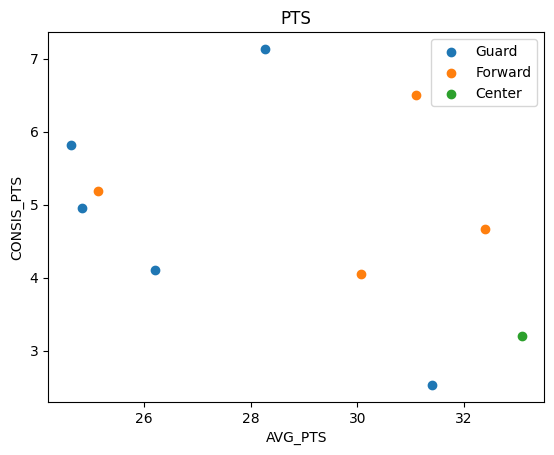

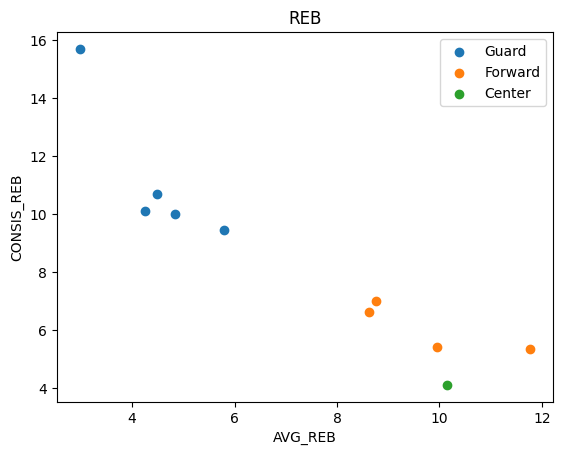

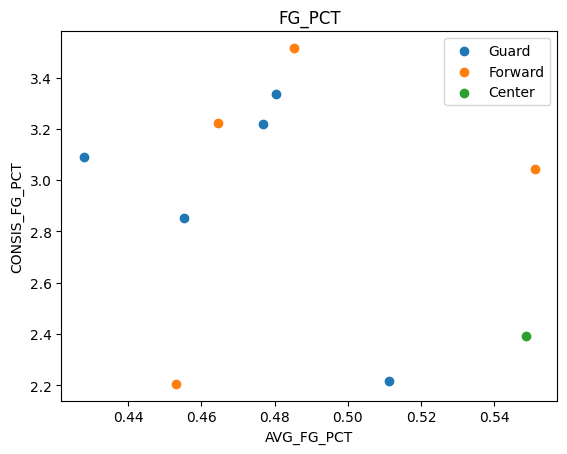

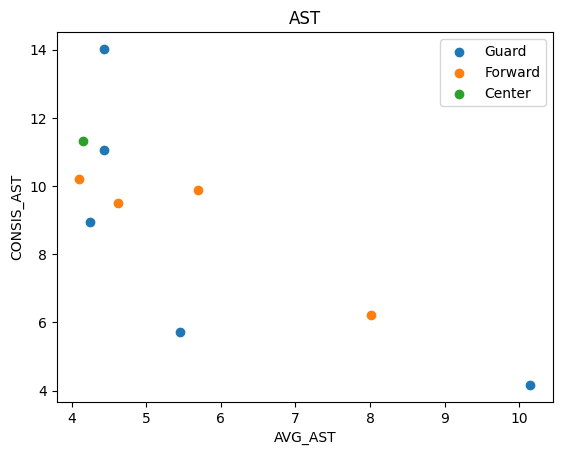

In [ ]:
for s in stats:
  # print([consistency['AVG_' + s][c] for c in range(len(consistency)) if consistency[]])
  for p in ['G', 'F', 'C']:
    avg = np.array([consistency['AVG_' + s][c] for c in consistency.index if consistency['POS'][c][0] == p])
    consis = np.array([consistency['CONSIS_' + s][c] for c in consistency.index if consistency['POS'][c][0] == p])
    # print(avg, p, s)
    plt.scatter(avg, consis)

  plt.xlabel(f"AVG_{s}")
  plt.ylabel(f"CONSIS_{s}")
  plt.title(s)

  # h, l = plt.get_legend_handles_labels()
  # print(h, l)
  plt.legend(['Guard', 'Forward', 'Center'])
  plt.show()